In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy.special import erfc
from numba import njit

In [2]:
# choosing parameters
np.random.seed(271)
n = 10000 # number of bits
fc = 10  # carrier frequency, Hz

rb = fc/2.  # bit rate, bits/s
Tb = 1./rb
end_time = n * Tb  # s
nb = 1000

k = 1.5  # ratio between 2 carrier's amplitude
A = 1  # carrier's amplitude
N0 = 18  # noise power spectral density

In [3]:
def plot_digital(digital_signal, nlim=None, n_ticks=11):
    plt.figure(figsize=(15, 3))
    digital_signal_2 = np.concatenate((digital_signal, [digital_signal[-1]]))
    plt.step(np.arange(0, Tb*len(digital_signal_2), Tb), digital_signal_2, where='post')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal')
    plt.yticks([0, 1])
    if nlim is None:
        plt.xlim(0, Tb*len(digital_signal_2)-Tb)
    else:
        plt.xlim(0, nlim*Tb)
    # plt.show()

def plot_analog_signal(signal, n_samples_per_sec=10000, n_ticks=11):
    t = np.linspace(0, end_time, int(n_samples_per_sec*end_time), endpoint=False)
    signal_t = np.array([signal(i) for i in t])
    plt.plot(t, signal_t)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (volts)')
    plt.xticks(np.linspace(0, end_time, n_ticks, dtype=np.float16), np.linspace(0, end_time, n_ticks, dtype=np.float16))
    plt.xlim(0, end_time)

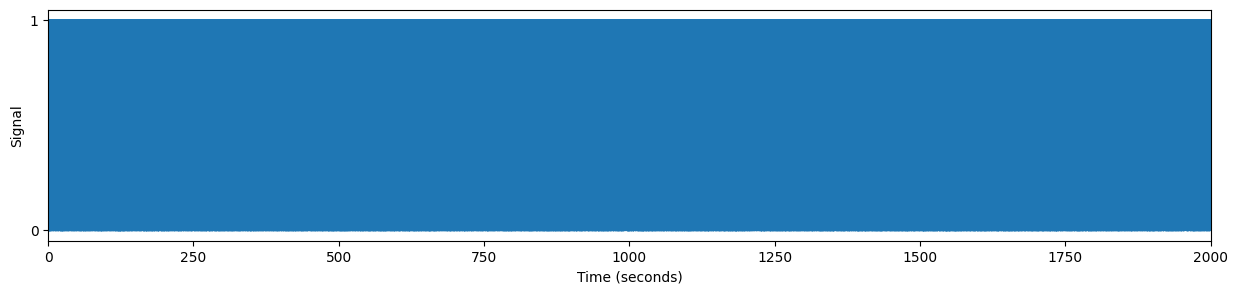

In [4]:
# input signal
rand_digital_signal = np.random.randint(0, 2, n)
plot_digital(rand_digital_signal)

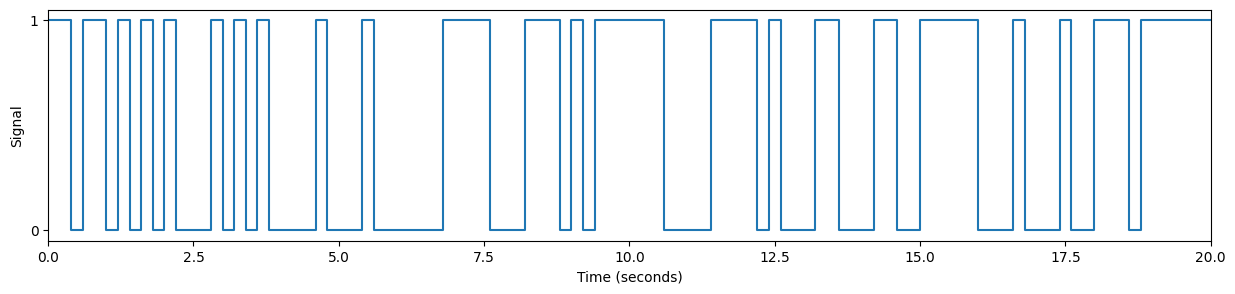

In [5]:
# first 100 input bits
plot_digital(rand_digital_signal, nlim=100)
plt.show()

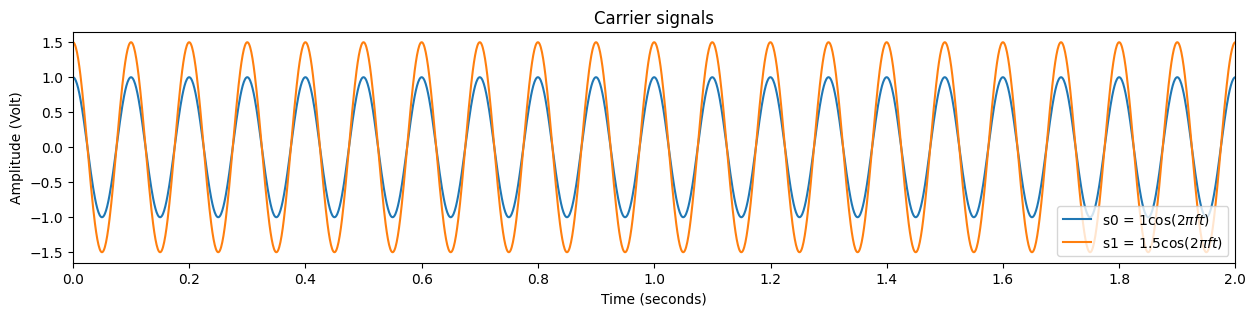

In [6]:
# Carrier signals
@njit
def carrier_0(t):
    return A * np.cos(2 * pi * fc * t)
@njit
def carrier_1(t):
    return k * A * np.cos(2 * pi * fc * t)
    
plt.figure(figsize=(15, 3))
plot_analog_signal(carrier_0, 1000, 10001)
plot_analog_signal(carrier_1, 1000, 10001)
plt.title('Carrier signals')
plt.xlim(0, 2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (Volt)')
plt.legend([f's0 = {A}$\cos(2\pi ft )$', f's1 = {A*k}$\cos(2\pi ft)$'], loc='lower right')
plt.show()

In [7]:
# Amplitude Shift Keying modulation
def ask_modulation(digital_signal, c0, c1):
    @njit
    def _fn(t):
        return c0(t) if digital_signal[int(t/Tb)] == 0 else c1(t)
    return _fn

# demodulation with correlation criteria
@njit
def ask_demodulation(signal):
    demod = np.empty(0)
    for t in range(n):
        t_range = np.arange(t*Tb, (t+1)*Tb, Tb/nb)
        signal_samples = np.array([signal(i) for i in t_range])
        # plt.plot(t_range, signal_samples)
        # plt.show()
        c0_samples = np.array([carrier_0(i) for i in t_range])
        c1_samples = np.array([carrier_1(i) for i in t_range])
        criteria0 = np.trapz((signal_samples-c0_samples/2)*c0_samples, t_range)
        criteria1 = np.trapz((signal_samples-c1_samples/2)*c1_samples, t_range)
        if criteria0 < criteria1:
            demod = np.append(demod, 1)
        else:
            demod = np.append(demod, 0)
    return demod.astype(np.int_)

# Gauss noise
def add_noise(signal, N0):
    @njit
    def _fn(t):
        return signal(t) + np.random.normal(0, np.sqrt(N0/2))
    return _fn

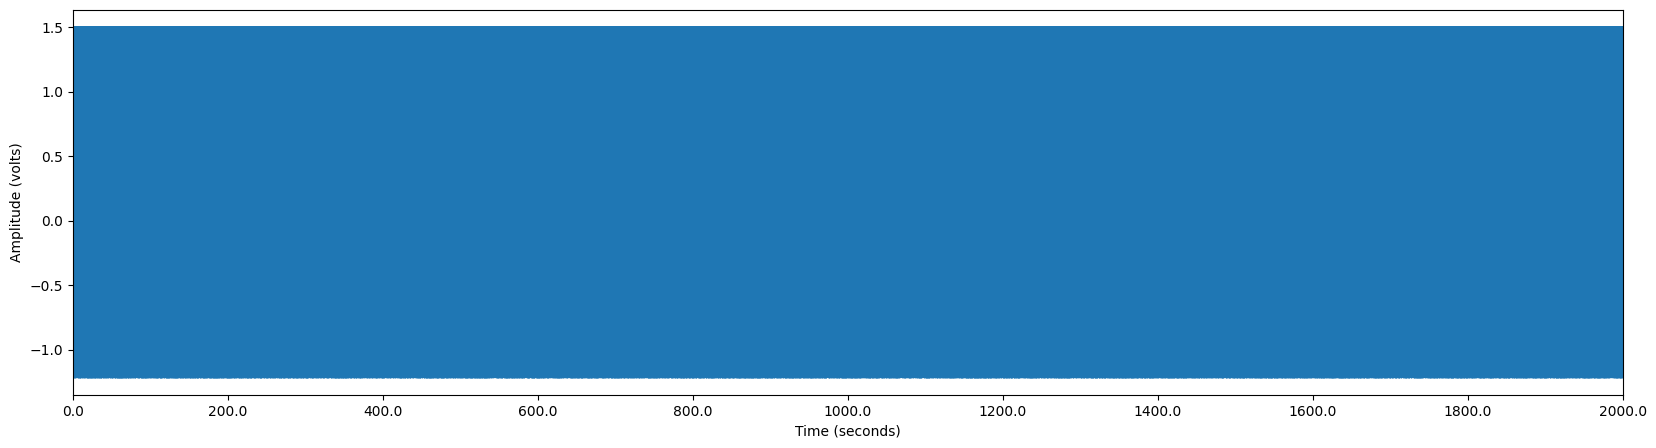

In [8]:
ask = ask_modulation(rand_digital_signal, carrier_0, carrier_1)
plt.figure(figsize=(20, 5))
plot_analog_signal(ask, n_samples_per_sec=50)

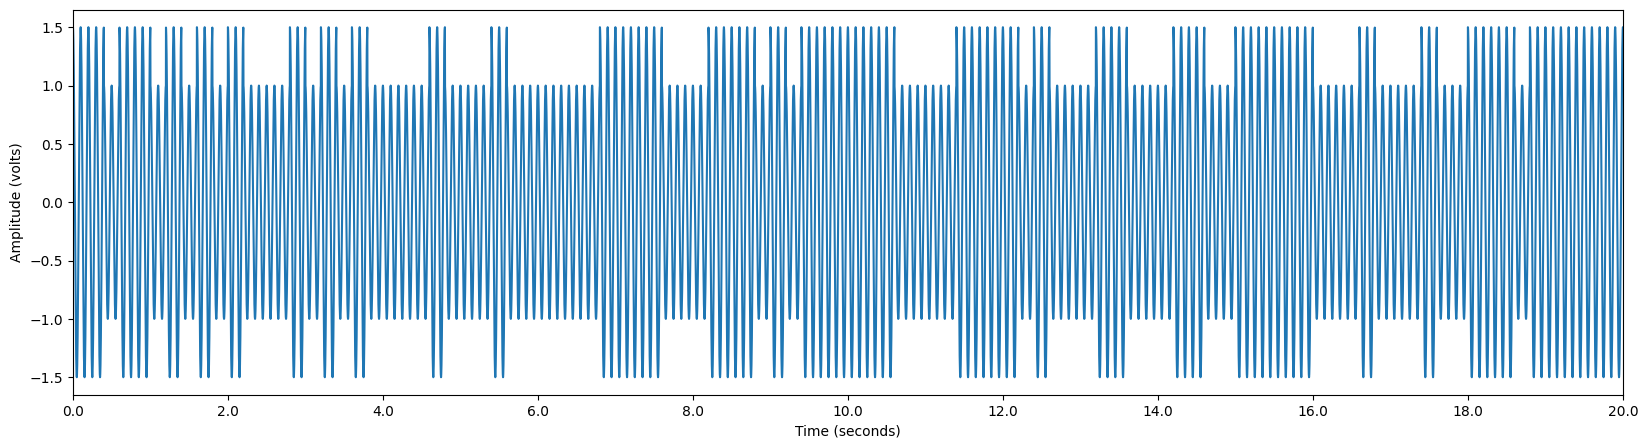

In [9]:
# first 100 bits after modulated
plt.figure(figsize=(20, 5))
plot_analog_signal(ask, n_samples_per_sec=1000, n_ticks=1001)
plt.xlim(0, 20)
plt.show()

BER = 0.0


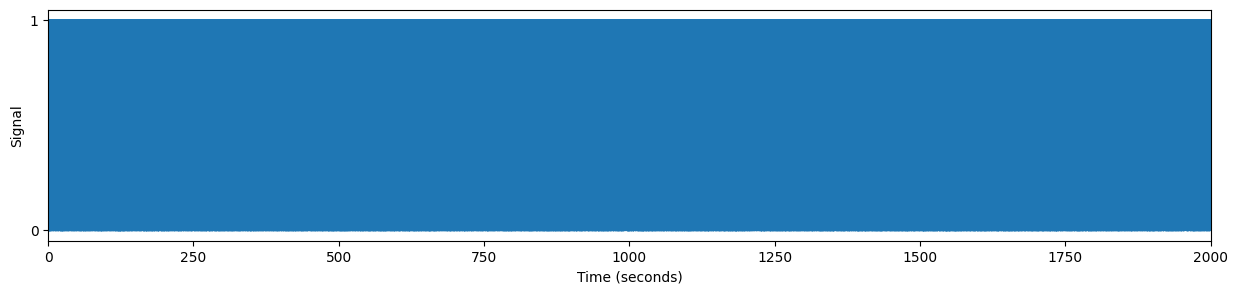

In [10]:
r = ask_demodulation(ask)
print('BER =', np.sum(np.abs(r-rand_digital_signal))/n)
plot_digital(r, n_ticks=11)

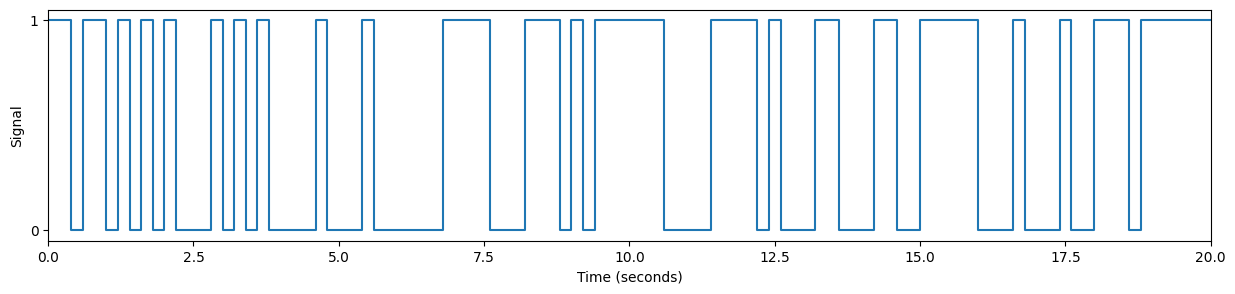

In [11]:
# first 100 demodulated bít
plot_digital(r, nlim=100)

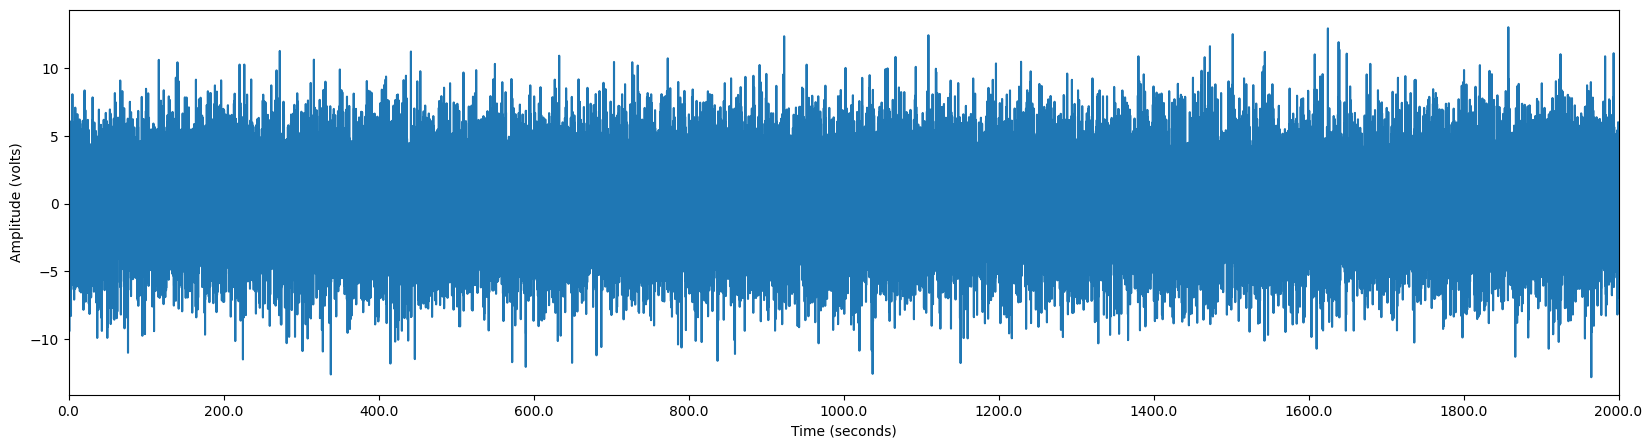

In [12]:
ask_noise = add_noise(ask, N0)
plt.figure(figsize=(20, 5))
plot_analog_signal(ask_noise, n_samples_per_sec=20)

bit diff:  313
BER = 3.13%


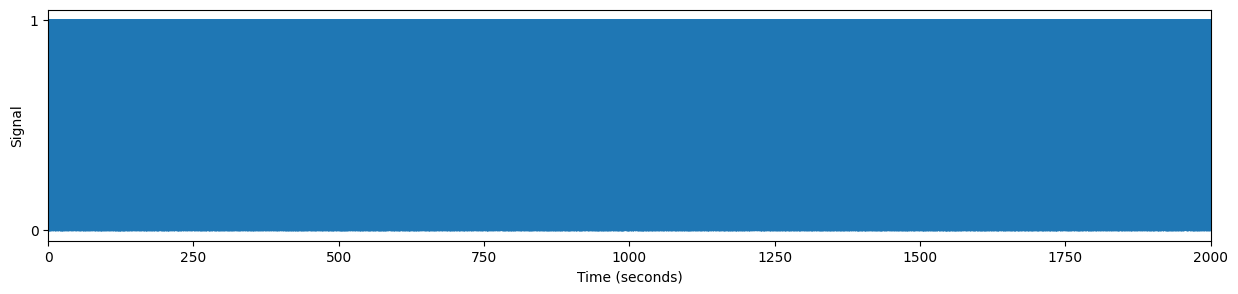

In [13]:
demod_ask_noise = ask_demodulation(ask_noise)
bit_diff = np.abs(demod_ask_noise - rand_digital_signal).sum()
print('bit diff: ', bit_diff)
print('BER = {}%'.format(np.around(100*bit_diff/n, 2)))
plot_digital(demod_ask_noise, n_ticks=11)

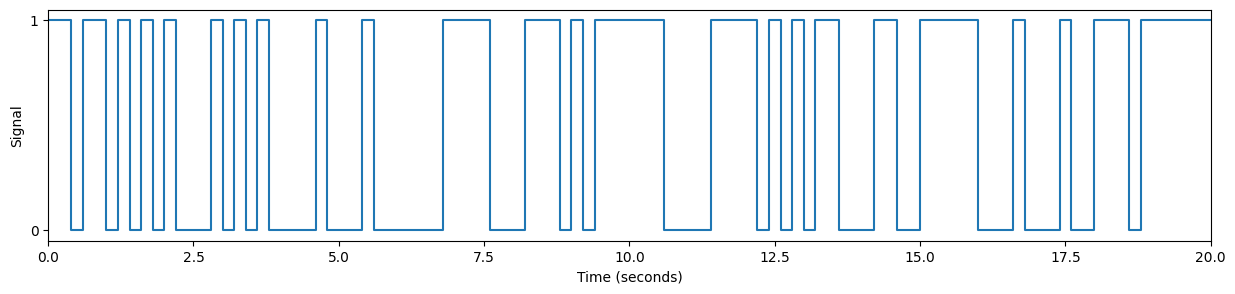

In [14]:
# first 100 demodulated bits
plot_digital(demod_ask_noise, nlim=100)

In [16]:
E1 = np.trapz(carrier_1(np.arange(0, Tb, Tb/nb))**2)
E0 = np.trapz(carrier_0(np.arange(0, Tb, Tb/nb))**2)
Eb = (E0+E1)/2
print('Theoretical BER: {}%'.format(np.around(100*1/2 * erfc((k-1)/np.sqrt(2*k*k+2)*np.sqrt(Eb/N0)), 5)))

Theoretical BER: 3.1335%
